In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.metrics import classification_report, confusion_matrix
import xgboost as xgb
import numpy as np
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
import warnings

warnings.filterwarnings("ignore")


# load data
weather = pd.read_csv("climatedatawithdate.csv")
weather.head()


,puttalam,tauu,rlus,sfcWind,rsuscs,rsus,rsdscs,prw,hurs,rtmt,...,tasmax,tasmin,tauv,tro3_500,tro3_850,ts,uas,wap_850,zg_850,date
0,63.3,0.152785,0.142045,0.477828,0.454995,0.497287,0.322817,0.440015,0.638365,0.298824,...,0.135349,0.221053,0.224634,0.673354,0.863010,0.147308,0.130948,0.736840,0.739986,1/1/1980
1,65.8,0.160138,0.264588,0.367296,0.726774,0.744863,0.662825,0.319734,0.468713,0.599960,...,0.374378,0.241274,0.308724,0.710253,0.673910,0.286245,0.128115,0.909573,0.615100,2/1/1980
2,101.1,0.244791,0.591772,0.126316,0.988048,0.980332,0.980188,0.177955,0.008800,0.629573,...,0.728056,0.390637,0.452436,0.705782,0.774462,0.631751,0.235086,0.537343,0.570181,3/1/1980
3,247.1,0.492494,0.779492,0.319731,0.857485,0.641255,0.986357,0.480825,0.305399,0.768145,...,0.744221,0.743645,0.677382,0.514572,0.602426,0.784966,0.583027,0.433170,0.519760,4/1/1980
4,93.7,0.659536,0.821613,0.617099,0.633129,0.734383,0.829791,0.406790,0.416917,0.681049,...,0.836437,0.786981,0.815424,0.997094,0.698438,0.828084,0.768470,0.795436,0.402319,5/1/1980


In [2]:
weather.isna().sum().sum()

0

In [3]:
# Create a target column
weather['date'] = pd.to_datetime(weather['date'])  # Convert 'Date' column to DateTime format
weather.sort_values(by='date', inplace=True)

weather['target'] = weather['puttalam'].shift(-1)
weather.dropna(inplace=True)        # Drop the last row
weather.head()


,puttalam,tauu,rlus,sfcWind,rsuscs,rsus,rsdscs,prw,hurs,rtmt,...,tasmin,tauv,tro3_500,tro3_850,ts,uas,wap_850,zg_850,date,target
0,63.3,0.152785,0.142045,0.477828,0.454995,0.497287,0.322817,0.440015,0.638365,0.298824,...,0.221053,0.224634,0.673354,0.863010,0.147308,0.130948,0.736840,0.739986,1980-01-01,65.8
1,65.8,0.160138,0.264588,0.367296,0.726774,0.744863,0.662825,0.319734,0.468713,0.599960,...,0.241274,0.308724,0.710253,0.673910,0.286245,0.128115,0.909573,0.615100,1980-02-01,101.1
2,101.1,0.244791,0.591772,0.126316,0.988048,0.980332,0.980188,0.177955,0.008800,0.629573,...,0.390637,0.452436,0.705782,0.774462,0.631751,0.235086,0.537343,0.570181,1980-03-01,247.1
3,247.1,0.492494,0.779492,0.319731,0.857485,0.641255,0.986357,0.480825,0.305399,0.768145,...,0.743645,0.677382,0.514572,0.602426,0.784966,0.583027,0.433170,0.519760,1980-04-01,93.7
4,93.7,0.659536,0.821613,0.617099,0.633129,0.734383,0.829791,0.406790,0.416917,0.681049,...,0.786981,0.815424,0.997094,0.698438,0.828084,0.768470,0.795436,0.402319,1980-05-01,0.4


## Data preprocessing

In [4]:
# Checking Constant Features using VarianceThreshold

from sklearn.feature_selection import VarianceThreshold

numeric_data = weather.drop(['date'], axis=1)
constant_filter = VarianceThreshold(threshold=0)

#Fit and transforming on train data
data_constant = constant_filter.fit_transform(numeric_data)
print(data_constant.shape)

#Extracting all constant columns using get support function of our filter
constant_columns = [column for column in numeric_data.columns
                    if column not in numeric_data.columns[constant_filter.get_support()]]

#No. of constant columns
print(len(constant_columns))

#Constant columns names:
for column in constant_columns:
    print(column)

(431, 50)
0


In [5]:
# Checking Quasi-Constant Features

qcons_filter = VarianceThreshold(threshold=0.01)

#Fit and transforming on train data
data_qcons = qcons_filter.fit_transform(numeric_data)
print(data_qcons.shape)

#Extracting all Quasi constant columns using get support function of our filter
qcons_columns = [column for column in numeric_data.columns
                    if column not in numeric_data.columns[qcons_filter.get_support()]]

#No. of Quasi constant columns
print(len(qcons_columns))

#Quasi Constant columns names:
for column in qcons_columns:
    print(column)

(431, 50)
0


## Feature importances

In [6]:
# split train and test data
# train = weather[weather['date'] < pd.to_datetime("1/1/2006")]
# test = weather[weather['date'] > pd.to_datetime("1/1/2006")]

# X = weather.drop(['date', 'puttalam', 'target'], axis=1)
# y = weather['target']

weather4 = weather.copy()

X_train =  weather4[weather4['date'] < pd.to_datetime("1/1/2006")].drop(['date', 'target'], axis=1)
y_train = weather4[weather4['date'] < pd.to_datetime("1/1/2006")]['target']

X_test =  weather4[weather4['date'] > pd.to_datetime("1/1/2006")].drop(['date', 'target'], axis=1)
y_test = weather4[weather4['date'] > pd.to_datetime("1/1/2006")]['target']

In [7]:
from sklearn.ensemble import RandomForestRegressor  # For regression tasks
from sklearn.ensemble import RandomForestClassifier  # For classification tasks
from xgboost import XGBRegressor, XGBClassifier  # XGBoost

# Example with Random Forest for regression
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [8]:
feature_importances = model.feature_importances_


In [9]:
# For example, selecting the top 25 most important features
sorted_indices = feature_importances.argsort()[::-1]
selected_features = X_train.columns[sorted_indices[:30]]
selected_features

Index(['rsuscs', 'wap_850', 'tro3_500', 'sbl', 'puttalam', 'sfcWind', 'rtmt',
       'va_500', 'tro3_850', 'rsds', 'rsutcs', 'rsdt', 'ta_850', 'rsus',
       'hurs', 'rsdscs', 'clwvi', 'hfss', 'ua_500', 'va_850', 'ta_500', 'clt',
       'zg_850', 'hfls', 'clivi', 'rlutcs', 'prc', 'zg_500', 'prw', 'evspsbl'],
      dtype='object')

## XGB

In [10]:
# Apply xgb
model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)
model.fit(X_train[selected_features], y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=42, ...)

In [11]:
y_pred = model.predict(X_test[selected_features])
mse = mean_squared_error(y_test, y_pred)
mse

6982.558648526843

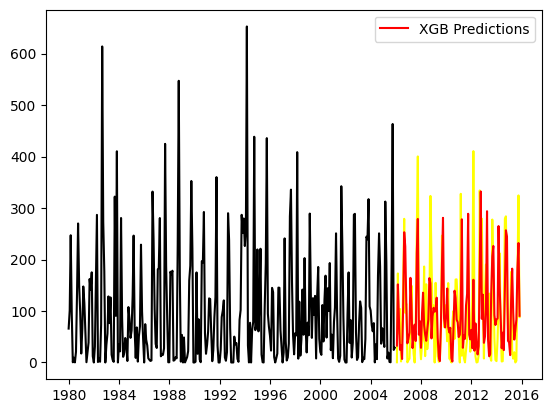

In [12]:
# plotting
train_dates = weather4[weather4['date'] < pd.to_datetime("1/1/2006")]['date']
test_dates = weather4[weather4['date'] > pd.to_datetime("1/1/2006")]['date']

plt.plot(train_dates, y_train.values, color="black")
plt.plot(test_dates, y_test.values, color="yellow")
plt.plot(test_dates, y_pred, color='red', label = 'XGB Predictions')

plt.legend()

## Random forest

In [13]:
from sklearn.ensemble import RandomForestRegressor

# Initialize the Random Forest regressor with your desired hyperparameters
model = RandomForestRegressor(n_estimators=100, random_state=42)

model.fit(X_train[selected_features], y_train)

RandomForestRegressor(random_state=42)

In [14]:
y_pred = model.predict(X_test[selected_features])
mse = mean_squared_error(y_test, y_pred)
mse

4943.850279381355

## Holt-Winters Exponential Smoothing model

Holt-Winters MSE: 10184.875515653217


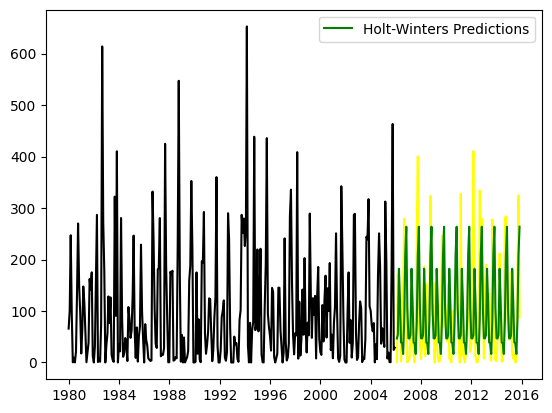

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm

# Split your data into training and testing sets
train_data = weather4[weather4['date'] < pd.to_datetime("1/1/2006")]
test_data = weather4[weather4['date'] > pd.to_datetime("1/1/2006")]

y_train = train_data['target']
y_test = test_data['target']

# Create and fit the Holt-Winters Exponential Smoothing model
model = sm.tsa.ExponentialSmoothing(y_train, seasonal='add', seasonal_periods=12)
model_fit = model.fit()

# Make predictions for the test set
y_pred_hw = model_fit.forecast(steps=len(test_data))

# Calculate the Mean Squared Error (MSE) for the Holt-Winters Exponential Smoothing model's predictions
mse_hw = mean_squared_error(y_test, y_pred_hw)
print(f"Holt-Winters MSE: {mse_hw}")

# Plot the Holt-Winters predictions along with the actual data
plt.plot(train_data['date'], y_train.values, color="black")
plt.plot(test_data['date'], y_test.values, color="yellow")
plt.plot(test_data['date'], y_pred_hw, color='green', label='Holt-Winters Predictions')

plt.legend()
plt.show()


## lstm

In [22]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.metrics import classification_report, confusion_matrix
import xgboost as xgb
import numpy as np
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
import warnings

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler

warnings.filterwarnings("ignore")


# load data
weather = pd.read_csv("climatedatawithdate.csv")

# Create a target column
weather['date'] = pd.to_datetime(weather['date'])  # Convert 'Date' column to DateTime format
weather.sort_values(by='date', inplace=True)

weather['target'] = weather['puttalam'].shift(-1)
weather.dropna(inplace=True)        # Drop the last row


weather4 = weather.copy()

# X_train =  weather4[weather4['date'] < pd.to_datetime("1/1/2006")].drop(['date', 'target'], axis=1)
# y_train = weather4[weather4['date'] < pd.to_datetime("1/1/2006")]['target']

# X_test =  weather4[weather4['date'] > pd.to_datetime("1/1/2006")].drop(['date', 'target'], axis=1)
# y_test = weather4[weather4['date'] > pd.to_datetime("1/1/2006")]['target']

In [23]:
weather4.set_index('date', inplace=True)
weather4.head()

,puttalam,tauu,rlus,sfcWind,rsuscs,rsus,rsdscs,prw,hurs,rtmt,...,tasmax,tasmin,tauv,tro3_500,tro3_850,ts,uas,wap_850,zg_850,target
date,,,,,,,,,,,,,,,,,,,,,
1980-01-01,63.3,0.152785,0.142045,0.477828,0.454995,0.497287,0.322817,0.440015,0.638365,0.298824,...,0.135349,0.221053,0.224634,0.673354,0.863010,0.147308,0.130948,0.736840,0.739986,65.8
1980-02-01,65.8,0.160138,0.264588,0.367296,0.726774,0.744863,0.662825,0.319734,0.468713,0.599960,...,0.374378,0.241274,0.308724,0.710253,0.673910,0.286245,0.128115,0.909573,0.615100,101.1
1980-03-01,101.1,0.244791,0.591772,0.126316,0.988048,0.980332,0.980188,0.177955,0.008800,0.629573,...,0.728056,0.390637,0.452436,0.705782,0.774462,0.631751,0.235086,0.537343,0.570181,247.1
1980-04-01,247.1,0.492494,0.779492,0.319731,0.857485,0.641255,0.986357,0.480825,0.305399,0.768145,...,0.744221,0.743645,0.677382,0.514572,0.602426,0.784966,0.583027,0.433170,0.519760,93.7
1980-05-01,93.7,0.659536,0.821613,0.617099,0.633129,0.734383,0.829791,0.406790,0.416917,0.681049,...,0.836437,0.786981,0.815424,0.997094,0.698438,0.828084,0.768470,0.795436,0.402319,0.4


In [24]:
# from sklearn.preprocessing import MinMaxScaler
min_max_scaler = MinMaxScaler(feature_range=(0, 1))
dataset = min_max_scaler.fit_transform(weather4['target'].values.reshape(-1, 1))

In [25]:
# split into train and test sets
train_size = int(len(dataset) * 0.7)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print(len(train), len(test))

301 130


In [26]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=15):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

In [27]:
x_train, y_train = create_dataset(train, look_back=15)
x_test, y_test = create_dataset(test, look_back=15)

In [28]:
x_train = np.reshape(x_train, (x_train.shape[0], 1, x_train.shape[1]))
x_test = np.reshape(x_test, (x_test.shape[0], 1, x_test.shape[1]))

In [29]:
# create and fit the LSTM network
look_back = 15
model = Sequential()
model.add(LSTM(20, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(x_train, y_train, epochs=20, batch_size=1, verbose=2)

Epoch 1/20
285/285 - 3s - loss: 0.0292 - 3s/epoch - 12ms/step
Epoch 2/20
285/285 - 1s - loss: 0.0221 - 541ms/epoch - 2ms/step
Epoch 3/20
285/285 - 1s - loss: 0.0210 - 551ms/epoch - 2ms/step
Epoch 4/20
285/285 - 1s - loss: 0.0205 - 556ms/epoch - 2ms/step
Epoch 5/20
285/285 - 1s - loss: 0.0202 - 560ms/epoch - 2ms/step
Epoch 6/20
285/285 - 1s - loss: 0.0202 - 782ms/epoch - 3ms/step
Epoch 7/20
285/285 - 1s - loss: 0.0199 - 519ms/epoch - 2ms/step
Epoch 8/20
285/285 - 1s - loss: 0.0197 - 524ms/epoch - 2ms/step
Epoch 9/20
285/285 - 1s - loss: 0.0193 - 512ms/epoch - 2ms/step
Epoch 10/20
285/285 - 1s - loss: 0.0194 - 531ms/epoch - 2ms/step
Epoch 11/20
285/285 - 1s - loss: 0.0191 - 516ms/epoch - 2ms/step
Epoch 12/20
285/285 - 1s - loss: 0.0194 - 547ms/epoch - 2ms/step
Epoch 13/20
285/285 - 1s - loss: 0.0191 - 533ms/epoch - 2ms/step
Epoch 14/20
285/285 - 1s - loss: 0.0191 - 524ms/epoch - 2ms/step
Epoch 15/20
285/285 - 1s - loss: 0.0189 - 534ms/epoch - 2ms/step
Epoch 16/20
285/285 - 1s - loss: 0.0

In [30]:
import math

trainPredict = model.predict(x_train)
testPredict = model.predict(x_test)
# invert predictions
trainPredict = min_max_scaler.inverse_transform(trainPredict)
trainY = min_max_scaler.inverse_transform([y_train])
testPredict = min_max_scaler.inverse_transform(testPredict)
testY = min_max_scaler.inverse_transform([y_test])
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))
testScore = mean_squared_error(testY[0], testPredict[:,0])
print('Test Score: %.2f MSE' % (testScore))

4/4 [==============================] - 0s 3ms/step
Train Score: 86.74 RMSE
Test Score: 78.20 RMSE
Test Score: 6115.60 MSE


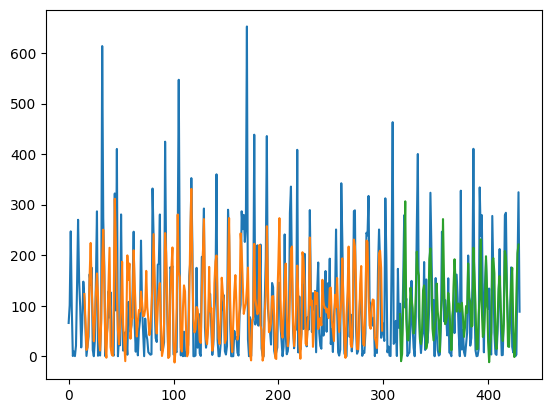

In [31]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
# plot baseline and predictions
plt.plot(min_max_scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()